## Task2:机器学习用于真实时间序列预测

### 数据导入并绘制序列

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import random
torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
# 数据导入
data = pd.read_csv('exp3data/alcohol.csv', index_col=0)
data = data.dropna().interpolate(method='linear')
data.head(13)

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
1992-06-01,4529
1992-07-01,4466
1992-08-01,4137
1992-09-01,4126


In [3]:
# 绘制序列
def plot_series(time, series, format="-", start=0, end=None, label=None):
    # 根据时间轴和对应数据列表绘制序列图
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    # 设置图例说明字体大小
    if label:
        plt.legend(fontsize=14)
    # 设置网格线
    plt.grid(True)

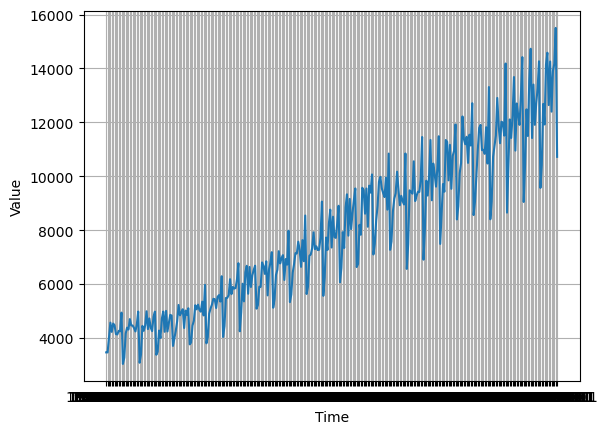

In [94]:
plot_series(data.index, data['S4248SM144NCEN'])

### 数据处理

1. 划分训练集、测试集

In [4]:
def train_test_split(series, split_prop):
    train = series[:int(split_prop * int(series.size))]
    test = series[int(split_prop * int(series.size)):]
    return train, test

2. 滑窗、划分特征/标签函数

In [5]:
def data_process(train, test, window_size):
    # 将数据直接转为tensor
    train_tensor = torch.tensor(train.values).squeeze(1)
    test_tensor = torch.tensor(test.values).squeeze(1)
    
    # 滑窗，得到短序列
    train_window_split = train_tensor.unfold(0, window_size, 1)
    train_set = train_window_split.numpy()
     
    test_window_split = test_tensor.unfold(0, window_size, 1)
    test_set = test_window_split.numpy()
    
    # 打乱训练集短序列数据
    train_templ = train_set.tolist()
    random.shuffle(train_templ)
    train_templ2 = np.array(train_templ)
    
    # 将短序列划分为feature和label
    train_feature_array = train_templ2[:, :window_size-1]
    train_label_array = train_templ2[:, window_size-1:]
    test_feature_array = test_set[:, :window_size-1]
    test_label_array = test_set[:, window_size-1:]
    
    # 转为tensor
    train_feature = torch.tensor(train_feature_array)
    train_label_temp = torch.tensor(train_label_array)
    test_feature = torch.tensor(test_feature_array)
    test_label_temp = torch.tensor(test_label_array)
    
    # 将label张量降维，去除维度为1的维度
    train_label = train_label_temp.squeeze()
    test_label = test_label_temp.squeeze()
    
    return train_feature, train_label, test_feature, test_label

3. 划分batch函数

In [6]:
# 将数据划分为指定大小的batch
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    for i in range(0, num_examples, batch_size):
        # 最后一次可能不足一个batch
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) 
        yield  features.index_select(0, j), labels.index_select(0, j)

4. 设置划分比例进行划分，设置滑窗大小将长序列变为短序列、划分特征与标签等

In [7]:
split_prop = 0.7
train, test = train_test_split(data, split_prop)
window_size = 13 # 12+1
train_feature, train_label, test_feature, test_label = data_process(train, test, window_size)

print(train_feature.shape)
print(train_label.shape)
print(test_feature.shape)
print(test_label.shape)

torch.Size([215, 12])
torch.Size([215])
torch.Size([86, 12])
torch.Size([86])


### 神经网络

构建3层前馈神经网络

In [8]:
# 实现FlattenLayer层
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)
    
# 定义模型输入、输出、隐藏层维度
num_inputs, num_outputs, num_hiddens = 12, 1, 3

# 定义模型
net1 = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs)
)

In [9]:
# 损失函数
def squared_loss(y_hat, y):
    return (y_hat - y.view(y_hat.size())) ** 2 / (y.shape[0])

learning rate = 0.1

In [10]:
# 参数初始化
for params in net1.parameters():
    nn.init.normal_(params, mean=0, std=0.01)
    
lr = 0.1
num_epochs = 200
batch_size = 64
loss = squared_loss
# loss = nn.MSELoss() # 均方误差损失函数
optimizer = torch.optim.Adam(net1.parameters(), lr=lr) # Adam优化器

训练模型

In [11]:
train_loss = []
test_loss = []

# 模型训练
for epoch in range(num_epochs): # 外循环训练一轮
    train_l, test_l = 0.0, 0.0
    for X, y in data_iter(batch_size, train_feature, train_label): # 内循环训练一个batch
        X = X.double()  
        y = y.double()  
        y_hat = net1(X)
        l = loss(y_hat, y).sum()
        # 梯度清零
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        # 反向传播
        l.backward()
        # 更新参数
        optimizer.step()
        
    # 该轮训练结束后，计算训练集和测试集的损失（每个样本的平均损失）
    train_feature = train_feature.double()  
    train_label = train_label.double()  
    test_feature = test_feature.double() 
    test_label = test_label.double()  
    train_l = loss(net1(train_feature), train_label).mean().item()
    test_l = loss(net1(test_feature), test_label).mean().item()
    train_loss.append(train_l)
    test_loss.append(test_l)
    print('epoch %d, train loss %f, test loss %f' % (epoch, train_l, test_l))

epoch 0, train loss 43675.098664, test loss 321048.347766
epoch 1, train loss 13139.443691, test loss 98036.410328
epoch 2, train loss 12997.157999, test loss 96985.053346
epoch 3, train loss 18688.564276, test loss 138682.817218
epoch 4, train loss 6287.473546, test loss 48066.236507
epoch 5, train loss 4525.927541, test loss 35209.855224
epoch 6, train loss 7399.590807, test loss 56210.409248
epoch 7, train loss 4395.694825, test loss 34196.762854
epoch 8, train loss 2495.294782, test loss 20327.753434
epoch 9, train loss 3348.394509, test loss 26523.605822
epoch 10, train loss 3471.407124, test loss 27353.021038
epoch 11, train loss 2658.382208, test loss 21398.831823
epoch 12, train loss 2333.346781, test loss 18979.588752
epoch 13, train loss 2395.597726, test loss 19387.115596
epoch 14, train loss 2425.302060, test loss 19556.913758
epoch 15, train loss 2384.246912, test loss 19211.188202
epoch 16, train loss 2247.801272, test loss 18163.958087
epoch 17, train loss 2175.030822, t

5. 绘制损失函数Loss曲线

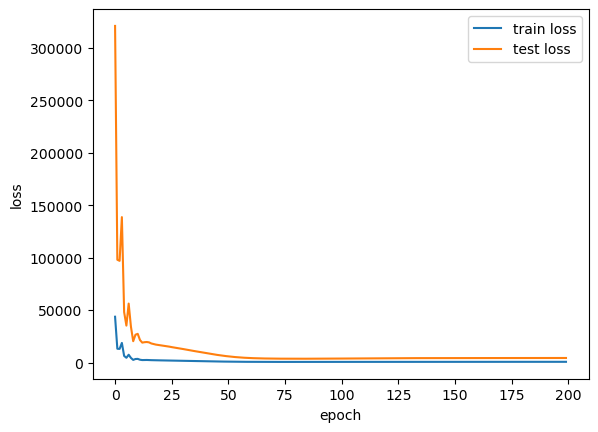

In [12]:
x = np.arange(num_epochs)
plt.plot(x, train_loss, label='train loss', linewidth=1.5)
plt.plot(x, test_loss, label='test loss', linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

6. 预测并对比

In [13]:
def predict(x):
    # 将输入数据从 DataFrame 转换为 NumPy 数组
    if isinstance(x, pd.DataFrame):
        x = x.values
    temp = torch.from_numpy(x).double().squeeze(1)  # 将数据类型转换为 Double
    # print('temp:', temp.shape)
    x_tensor = temp.reshape(1, 1, window_size-1)  # (batch_size, feature_size)
    # print('x_tensor:', x_tensor.shape)
    return net1(x_tensor)

[array(10808.04063785),
 array(6643.7558509),
 array(7884.41541548),
 array(9609.91530019),
 array(9255.73146552),
 array(9630.18201979),
 array(10586.54630285),
 array(8997.28751271),
 array(9567.40830036),
 array(9527.46739267),
 array(9376.36911918),
 array(10331.62949709),
 array(11367.3090059),
 array(7006.68429999),
 array(8473.04191124),
 array(9885.89236189),
 array(9189.08673913),
 array(10271.37953817),
 array(11226.56830869),
 array(9153.53632873),
 array(10750.5092995),
 array(10099.81166953),
 array(9713.27404544),
 array(10727.16945673),
 array(11355.81541956),
 array(7737.62922553),
 array(9011.20174201),
 array(9750.29164863),
 array(9499.83502077),
 array(11477.82795063),
 array(11233.93775858),
 array(9999.96516492),
 array(11294.4998439),
 array(9677.61869794),
 array(10883.02098538),
 array(11284.12696177),
 array(11896.56257606),
 array(8631.99336026),
 array(9217.70580019),
 array(10238.5951476),
 array(10539.83799285),
 array(12254.06326613),
 array(11448.3696004

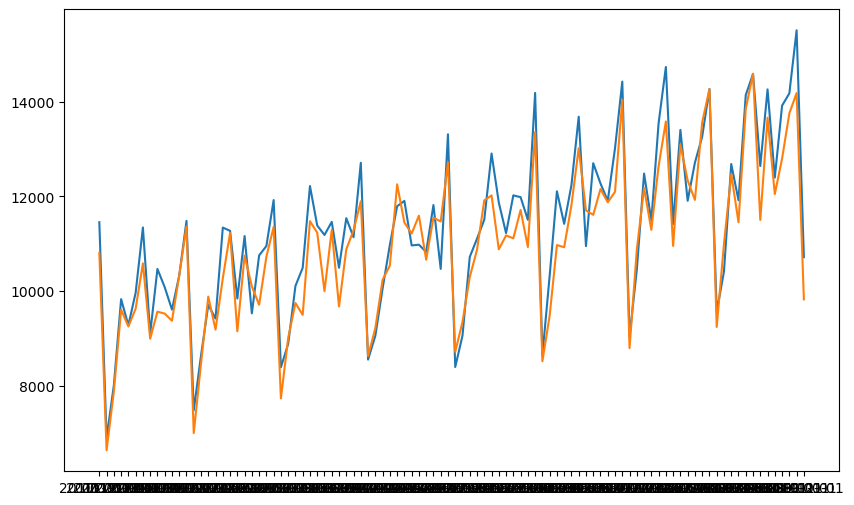

In [14]:
test_predict = []
split_point = int(split_prop * int(data.size))
# 针对测试集中的数据，按照滑窗大小取出特征，利用训练好的网络预测下一个值
for i in range((split_point - (window_size-1)), (data.size - (window_size-1))):
    x = data[i:(i + window_size-1)]
    y = predict(x)
    y = y.detach().numpy().squeeze()
    test_predict.append(y)
# 将测试集真实数据与网络预测数据以不同颜色绘制在一起，便于对比
plt.figure(figsize=(10, 6))
plt.plot(test)
plt.plot(test_predict)
test_predict

learning rate = 0.01

构建3层前馈神经网络

In [118]:
# 实现FlattenLayer层
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)
    
# 定义模型输入、输出、隐藏层维度
num_inputs, num_outputs, num_hiddens = 12, 1, 3

# 定义模型
net2 = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs)
)

In [119]:
# 参数初始化
for params in net2.parameters():
    nn.init.normal_(params, mean=0, std=0.01)
    
lr = 0.01
num_epochs = 150
batch_size = 128
# loss = squared_loss
loss = nn.MSELoss() # 均方误差损失函数
optimizer = torch.optim.Adam(net2.parameters(), lr=lr) # Adam优化器

训练模型

In [120]:
train_loss = []
test_loss = []

# 模型训练
for epoch in range(num_epochs): # 外循环训练一轮
    train_l, test_l = 0.0, 0.0
    for X, y in data_iter(batch_size, train_feature, train_label): # 内循环训练一个batch
        X = X.double()  
        y = y.double()  
        y_hat = net2(X)
        l = loss(y_hat, y).sum()
        # 梯度清零
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        # 反向传播
        l.backward()
        # 更新参数
        optimizer.step()
        
    # 该轮训练结束后，计算训练集和测试集的损失（每个样本的平均损失）
    train_feature = train_feature.double()  
    train_label = train_label.double()  
    test_feature = test_feature.double() 
    test_label = test_label.double()  
    train_l = loss(net2(train_feature), train_label).mean().item()
    test_l = loss(net2(test_feature), test_label).mean().item()
    train_loss.append(train_l)
    test_loss.append(test_l)
    print('epoch %d, train loss %f, test loss %f' % (epoch, train_l, test_l))

/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([87])) that is different to the input size (torch.Size([87, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([215])) that is different to the input size (torch.Size([215, 1])). This will likely lead to incorrect results due to broadc

epoch 0, train loss 44907947.634674, test loss 130840347.183473
epoch 1, train loss 41623912.589671, test loss 120635989.529622
epoch 2, train loss 36495011.179393, test loss 104636781.661412
epoch 3, train loss 29831805.423646, test loss 83707402.276371
epoch 4, train loss 22265198.922697, test loss 59650105.066164
epoch 5, train loss 14832217.850906, test loss 35466751.042668
epoch 6, train loss 9006903.471595, test loss 15482638.837571
epoch 7, train loss 6438487.199703, test loss 4677730.175470
epoch 8, train loss 7735899.047714, test loss 5344146.276679
epoch 9, train loss 10506591.048017, test loss 11398739.956129
epoch 10, train loss 11262707.535017, test loss 13188212.801672
epoch 11, train loss 9725488.531981, test loss 9592729.215575
epoch 12, train loss 7700418.739345, test loss 5276692.791961
epoch 13, train loss 6549594.821605, test loss 3679172.935566
epoch 14, train loss 6483191.088988, test loss 5030094.076187
epoch 15, train loss 6982962.837981, test loss 7600509.62398

5. 绘制损失函数Loss曲线

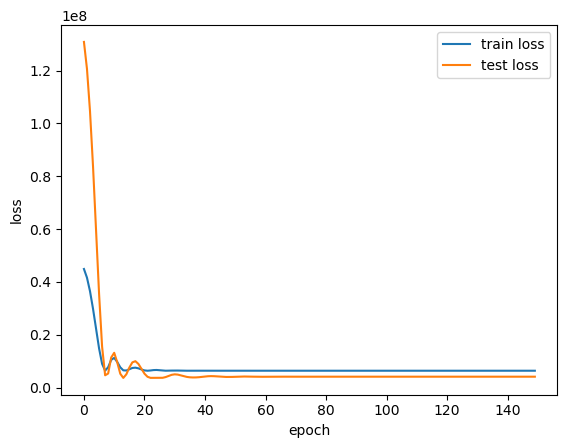

In [121]:
x = np.arange(num_epochs)
plt.plot(x, train_loss, label='train loss', linewidth=1.5)
plt.plot(x, test_loss, label='test loss', linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

6. 预测并对比

In [124]:
def predict(x):
    # 将输入数据从 DataFrame 转换为 NumPy 数组
    if isinstance(x, pd.DataFrame):
        x = x.values
    temp = torch.from_numpy(x).double().squeeze(1)  # 将数据类型转换为 Double
    # print('temp:', temp.shape)
    x_tensor = temp.reshape(1, 1, window_size-1)  # (batch_size, feature_size)
    # print('x_tensor:', x_tensor.shape)
    return net2(x_tensor)

[array(8826.73815927),
 array(8906.58959243),
 array(8937.38255025),
 array(8934.27426032),
 array(8934.29040118),
 array(8923.44044565),
 array(9010.93387961),
 array(9059.58692077),
 array(9086.94691127),
 array(9195.12937736),
 array(9213.10793927),
 array(9221.75278159),
 array(9282.65710649),
 array(9300.95377657),
 array(9361.00590006),
 array(9368.92154185),
 array(9328.43796806),
 array(9338.09733636),
 array(9474.34688989),
 array(9472.58706398),
 array(9546.82852573),
 array(9615.98482819),
 array(9541.85388886),
 array(9629.39085628),
 array(9692.12085951),
 array(9749.41773153),
 array(9849.58728221),
 array(9810.4885648),
 array(9821.97884493),
 array(9889.08703711),
 array(9993.87333649),
 array(10018.04005009),
 array(10128.78042017),
 array(10177.45271373),
 array(10210.58981333),
 array(10277.21637485),
 array(10294.31575628),
 array(10390.22950356),
 array(10424.25538715),
 array(10373.98228779),
 array(10348.16344578),
 array(10356.10286945),
 array(10377.91131207),


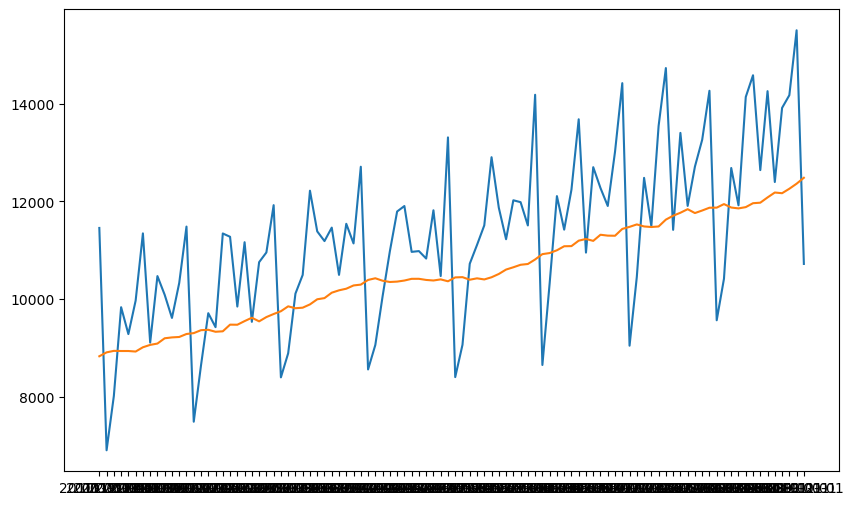

In [125]:
test_predict = []
split_point = int(split_prop * int(data.size))
# 针对测试集中的数据，按照滑窗大小取出特征，利用训练好的网络预测下一个值
for i in range((split_point - (window_size-1)), (data.size - (window_size-1))):
    x = data[i:(i + window_size-1)]
    y = predict(x)
    y = y.detach().numpy().squeeze()
    test_predict.append(y)
# 将测试集真实数据与网络预测数据以不同颜色绘制在一起，便于对比
plt.figure(figsize=(10, 6))
plt.plot(test)
plt.plot(test_predict)
test_predict

learning rate = 0.001

构建3层前馈神经网络

In [127]:
# 实现FlattenLayer层
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x): # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)
    
# 定义模型输入、输出、隐藏层维度
num_inputs, num_outputs, num_hiddens = 12, 1, 3

# 定义模型
net3 = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs)
)

In [128]:
# 参数初始化
for params in net3.parameters():
    nn.init.normal_(params, mean=0, std=0.01)
    
lr = 0.001
num_epochs = 150
batch_size = 128
# loss = squared_loss
loss = nn.MSELoss() # 均方误差损失函数
optimizer = torch.optim.Adam(net3.parameters(), lr=lr) # Adam优化器

训练模型

In [129]:
train_loss = []
test_loss = []

# 模型训练
for epoch in range(num_epochs): # 外循环训练一轮
    train_l, test_l = 0.0, 0.0
    for X, y in data_iter(batch_size, train_feature, train_label): # 内循环训练一个batch
        X = X.double()  
        y = y.double()  
        y_hat = net3(X)
        l = loss(y_hat, y).sum()
        # 梯度清零
        if optimizer is not None:
            optimizer.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        # 反向传播
        l.backward()
        # 更新参数
        optimizer.step()
        
    # 该轮训练结束后，计算训练集和测试集的损失（每个样本的平均损失）
    train_feature = train_feature.double()  
    train_label = train_label.double()  
    test_feature = test_feature.double() 
    test_label = test_label.double()  
    train_l = loss(net3(train_feature), train_label).mean().item()
    test_l = loss(net3(test_feature), test_label).mean().item()
    train_loss.append(train_l)
    test_loss.append(test_l)
    print('epoch %d, train loss %f, test loss %f' % (epoch, train_l, test_l))

/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([87])) that is different to the input size (torch.Size([87, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/data2/NieShiqin/anaconda3/envs/dl/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([215])) that is different to the input size (torch.Size([215, 1])). This will likely lead to incorrect results due to broadc

epoch 0, train loss 46257276.072155, test loss 135024648.631667
epoch 1, train loss 46194942.375064, test loss 134831428.660013
epoch 2, train loss 46116288.202492, test loss 134587599.028995
epoch 3, train loss 46020456.076762, test loss 134290491.949506
epoch 4, train loss 45906487.899426, test loss 133937124.825840
epoch 5, train loss 45773373.905816, test loss 133524351.497570
epoch 6, train loss 45620084.307194, test loss 133048959.799749
epoch 7, train loss 45445592.960485, test loss 132507744.389552
epoch 8, train loss 45248896.664197, test loss 131897566.000965
epoch 9, train loss 45029031.680515, test loss 131215402.095771
epoch 10, train loss 44785088.240341, test loss 130458391.266174
epoch 11, train loss 44516223.401366, test loss 129623872.545794
epoch 12, train loss 44221672.446823, test loss 128709420.220253
epoch 13, train loss 43900758.928381, test loss 127712874.467211
epoch 14, train loss 43552903.421226, test loss 126632368.045409
epoch 15, train loss 43177631.04793

5. 绘制损失函数Loss曲线

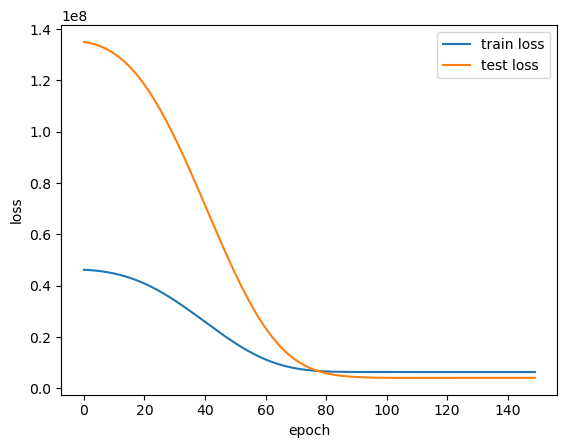

In [130]:
x = np.arange(num_epochs)
plt.plot(x, train_loss, label='train loss', linewidth=1.5)
plt.plot(x, test_loss, label='test loss', linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

6. 预测并对比

In [131]:
def predict(x):
    # 将输入数据从 DataFrame 转换为 NumPy 数组
    if isinstance(x, pd.DataFrame):
        x = x.values
    temp = torch.from_numpy(x).double().squeeze(1)  # 将数据类型转换为 Double
    # print('temp:', temp.shape)
    x_tensor = temp.reshape(1, 1, window_size-1)  # (batch_size, feature_size)
    # print('x_tensor:', x_tensor.shape)
    return net3(x_tensor)

[array(8813.26565256),
 array(8887.69923198),
 array(8886.55759726),
 array(8935.01751157),
 array(8974.52421415),
 array(8950.53145167),
 array(8998.89030293),
 array(9096.59095904),
 array(9064.76062949),
 array(9171.42230431),
 array(9227.3034896),
 array(9226.09139084),
 array(9265.01049878),
 array(9292.22866716),
 array(9304.64784187),
 array(9369.83457369),
 array(9365.79716141),
 array(9364.62274552),
 array(9482.00271035),
 array(9499.96360302),
 array(9528.86285565),
 array(9600.14469116),
 array(9548.04177775),
 array(9627.95322848),
 array(9687.30837935),
 array(9732.78624167),
 array(9782.70255633),
 array(9817.62956724),
 array(9844.30045225),
 array(9928.76237261),
 array(10001.67795047),
 array(10028.91431457),
 array(10117.06482522),
 array(10150.20240022),
 array(10216.45098891),
 array(10272.83129539),
 array(10293.87740132),
 array(10363.70081516),
 array(10362.22927884),
 array(10381.11509765),
 array(10376.3756091),
 array(10416.28894325),
 array(10379.51104635),


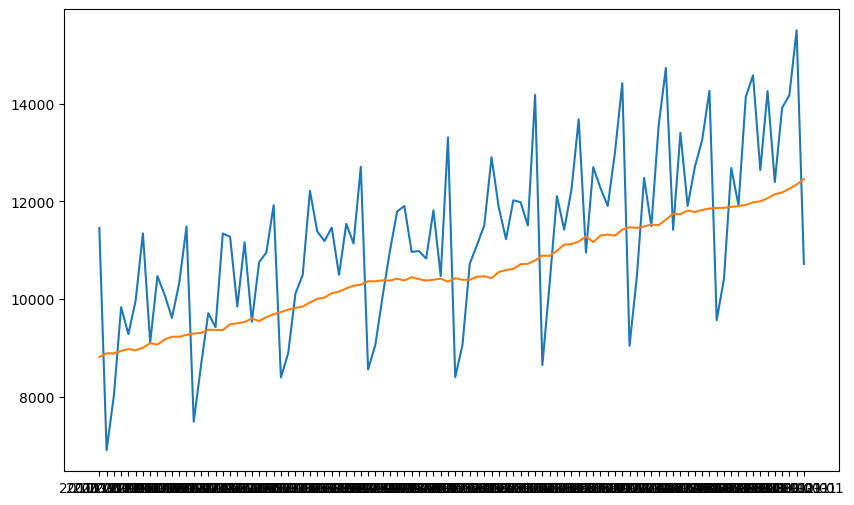

In [132]:
test_predict = []
split_point = int(split_prop * int(data.size))
# 针对测试集中的数据，按照滑窗大小取出特征，利用训练好的网络预测下一个值
for i in range((split_point - (window_size-1)), (data.size - (window_size-1))):
    x = data[i:(i + window_size-1)]
    y = predict(x)
    y = y.detach().numpy().squeeze()
    test_predict.append(y)
# 将测试集真实数据与网络预测数据以不同颜色绘制在一起，便于对比
plt.figure(figsize=(10, 6))
plt.plot(test)
plt.plot(test_predict)
test_predict

### 从结果来看，神经网络的拟合效果很差。三种学习率的结果都很差

### 使用SVR进行回归预测

In [136]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as mse

model = SVR(kernel='linear')
# 模型训练
model.fit(train_feature, train_label)
# 测试集预测
test_predict = model.predict(test_feature)
# 计算mse
mse = mse(test_label, test_predict)

print('使用SVR模型的测试集最终MSE:', mse)

使用SVR模型的测试集最终MSE: 309498.71262742573


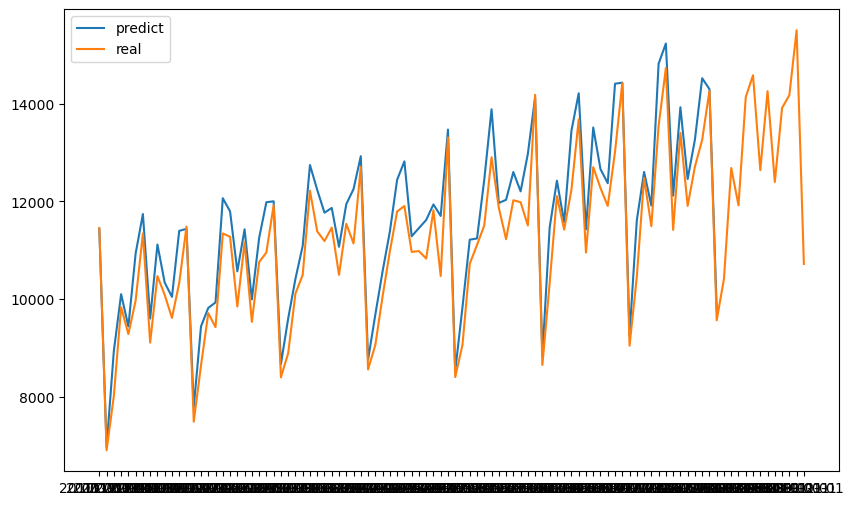

In [137]:
# 可视化
plt.figure(figsize=(10, 6))
plt.plot(test_predict, label='predict')
plt.plot(test, label = 'real')
plt.legend()

### 使用决策树

In [138]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse

model = DecisionTreeRegressor()
# 模型训练
model.fit(train_feature, train_label)
# 测试集预测
test_predict = model.predict(test_feature)
# 计算mse
mse = mse(test_label, test_predict)

print('使用决策树模型的测试集最终MSE:', mse)

使用决策树模型的测试集最终MSE: 4804549.337209302


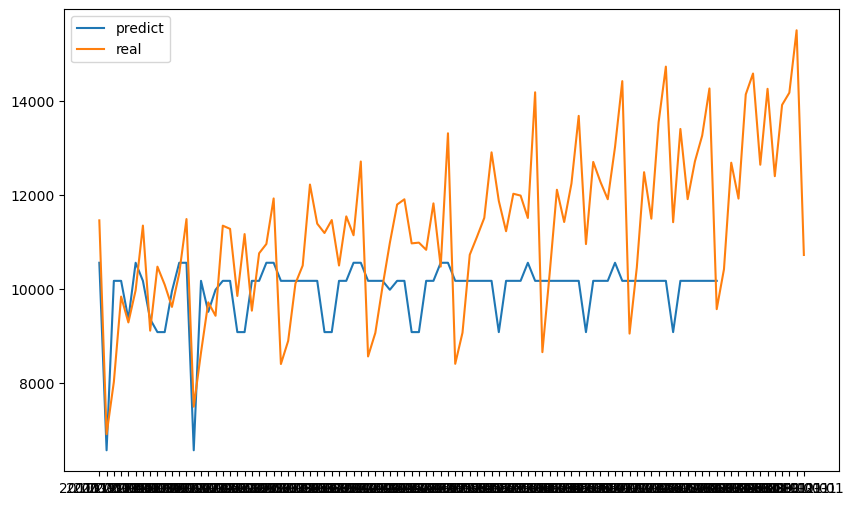

In [139]:
# 可视化
plt.figure(figsize=(10, 6))
plt.plot(test_predict, label='predict')
plt.plot(test, label = 'real')
plt.legend()

### 由此发现，机器学习模型的拟合效果要比神经网络模型拟合效果更好。同时，采用支持向量回归，并且当采用线性核的时候，模型的拟合效果最好。